# Lab 1: Linear Regression and Overfitting

### Machine Learning and Pattern Recognition, September 2016

* The lab exercises should be made in groups of two people.
* The deadline is sunday September 25, 23:59.
* Assignment should be sent to your teaching assistant. The subject line of your email should be "\#lab\_lastname1\_lastname2\_lastname3".
* Put your and your teammates' names in the body of the email
* Attach the .IPYNB (IPython Notebook) file containing your code and answers. Naming of the file follows the same rule as the subject line. For example, if the subject line is "lab01\_Kingma\_Hu", the attached file should be "lab01\_Kingma\_Hu.ipynb". Only use underscores ("\_") to connect names, otherwise the files cannot be parsed.
* Make sure we can run your notebook / scripts!

Notes on implementation:

* You should write your code and answers in this IPython Notebook: http://ipython.org/notebook.html. If you have problems, please contact your teaching assistant.
* Please write your answers right below the questions.
* Among the first lines of your notebook should be "%pylab inline". This imports all required modules, and your plots will appear inline.
* Refer to last week's lab notes, i.e. http://docs.scipy.org/doc/, if you are unsure about what function to use. There are different correct ways to implement each problem!
* For this lab, your regression solutions should be in closed form, i.e., should not perform iterative gradient-based optimization but find the exact optimum directly.

In [81]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

$\newcommand{\bPhi}{\mathbf{\Phi}}$
$\newcommand{\bx}{\mathbf{x}}$
$\newcommand{\bw}{\mathbf{w}}$
$\newcommand{\bt}{\mathbf{t}}$
$\newcommand{\by}{\mathbf{y}}$
$\newcommand{\bm}{\mathbf{m}}$
$\newcommand{\bS}{\mathbf{S}}$
$\newcommand{\bI}{\mathbf{I}}$

## Part 1: Polynomial Regression

### 1.1. Generate sinusoidal data (5 points)
Write a method `gen_sinusoidal(N)` that generates toy data like in fig 1.2 of Bishop's book. The method should have a parameter $N$, and should return $N$-dimensional vectors $\bx$ and $\bt$, where $\bx$ contains evenly spaced values from 0 to (including) 2$\pi$, and the elements $t_i$ of $\bt$ are distributed according to:

$$t_i \sim \mathcal{N}(\mu_i, \sigma^2)$$

where $x_i$ is the $i$-th elements of $\bf{x}$, the mean $\mu_i = sin(x_i)$ and the standard deviation $\sigma = 0.2$.


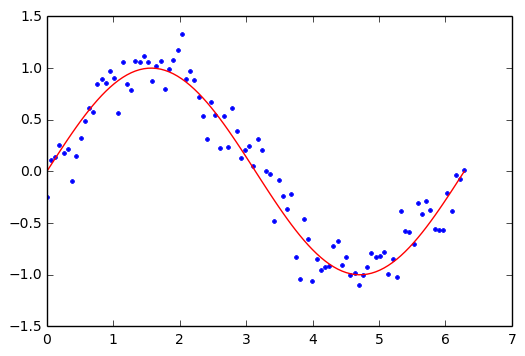

In [82]:
def gen_sinusoidal(N):
    sigma = 0.2
    
    # Create a linspace between 0 and 2pi with N points.
    x = np.linspace(0, 2 * np.pi, N)
    
    # Setup a mu with the points from the linspace
    mu = np.sin(x)
    
    # Create the normally distributed data
    t = np.random.normal(mu, sigma, N)
    
    return x, t

# Generate 100 sinusoidal datapoints
x, t = gen_sinusoidal(100)

# Plots the results with a sine from 0 to 2pi
plt.plot(x, t, 'b.')
plt.plot(x, np.sin(x), 'r-')
plt.show()



### 1.2 Polynomial regression (15 points)

Write a method `fit_polynomial(x, t, M)` that finds the maximum-likelihood solution of an _unregularized_ $M$-th order polynomial for some dataset `x`. The error function to minimize w.r.t. $\bw$ is:

$E(\bw) = \frac{1}{2} (\bPhi\bw - \bt)^T(\bPhi\bw - \bt)$

where $\bPhi$ is the _feature matrix_ (or _design matrix_) as explained in Bishop's book at section 3.1.1, $\bt$ is the vector of target values. Your method should return a vector $\bw$ with the maximum-likelihood parameter estimates. 

In [83]:
def fit_polynomial(x, t, M):
    Phi = np.array([x**i for i in range(M+1)]).T
    s1 = np.dot(np.linalg.inv(np.dot(Phi.T, Phi)), Phi.T)
    w_max = np.dot(s1, t)
    
    return w_max

### 1.3 Plot (5 points)
Sample a dataset with $N=9$, and fit four polynomials with $M \in (0, 1, 3, 9)$.
For each value of $M$, plot the prediction function, along with the data and the original sine function. The resulting figure should look similar to fig 1.4 of the Bishop's book. Note that you can use matplotlib's `plt.pyplot(.)` functionality for creating grids of figures.

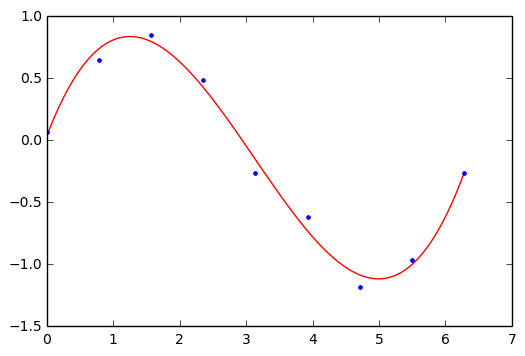

In [86]:
x1, t = gen_sinusoidal(N)

orders = [3]

for M in orders:
    w = fit_polynomial(x1, t, M)

    x2 = np.linspace(0, 2 * np.pi, 100)
    y2 = 0
    
    for i in range(M+1):
        y2 += w[i]*(x2**i)

    plt.plot(x2, y2, 'r-')

plt.plot(x1, t, 'b.')
plt.show()

### 1.4 Regularized linear regression (10 points)

Write a method `fit_polynomial_reg(x, t, M, lamb)` that fits a _regularized_ $M$-th order polynomial to the sinusoidal data, as discussed in the lectures, where `lamb` is the regularization term _lambda_. (Note that 'lambda' cannot be used as a variable name in Python since it has a special meaning). The error function to minimize w.r.t. $\bw$:

$E(\bw) = \frac{1}{2} (\bPhi\bw - \bt)^T(\bPhi\bw - \bt) + \frac{\lambda}{2} \mathbf{w}^T \mathbf{w}$

For background, see section 3.1.4 of Bishop's book.

In [87]:
def fit_polynomial_reg(x, t, M, lamb):
    Phi = np.array([x**i for i in range(M+1)]).T
    s1 = np.dot(np.linalg.inv(lamb*np.eye(np.dot(Phi.T, Phi).shape[0])+np.dot(Phi.T, Phi)), Phi.T)
    w_max = np.dot(s1, t)
    
    return w_max






### 1.5 Model selection by cross-validation (10 points)
Use cross-validation to find a good choice of $M$ and $\lambda$, given a dataset of $N=9$ datapoints generated with `gen_sinusoidal(9)`. You should write a function that tries (loops over) a reasonable range of choices of $M$ and $\lambda$, and returns the choice with the best cross-validation error. In this case you can use $K=9$ folds, corresponding to _leave-one-out_ crossvalidation.

You can let $M \in (0, 1, ..., 10)$, and let $\lambda \in (e^{-10}, e^{-9}, ..., e^{0})$.

To get you started, here's a method you can use to generate indices of cross-validation folds.

In [88]:
def kfold_indices(N, k):
    all_indices = np.arange(N,dtype=int)
    np.random.shuffle(all_indices)
    idx = np.floor(np.linspace(0,N,k+1))
    train_folds = []
    valid_folds = []
    for fold in range(k):
        valid_indices = all_indices[idx[fold]:idx[fold+1]]
        valid_folds.append(valid_indices)
        train_folds.append(np.setdiff1d(all_indices, valid_indices))
    return train_folds, valid_folds

def error_function(x, t, w):
    Phi = np.array([x**i for i in range(M+1)]).T
    s1 = (np.dot(Phi, w) - t)
    
    return np.dot(s1.T, s1)/2

N = 9

x, t = gen_sinusoidal(N)

orders = range(0,11)
lambdas = range(-10, 0)
orders = [3]
lambdas = [-4]
k = 9


best_error = 1000
for M in orders:
    for lamb in lambdas:
        errors = np.array([])
        tr_folds, va_folds = kfold_indices(N, k)
        for i in range(k):
            w = fit_polynomial_reg(x[tr_folds[i]], t[tr_folds[i]], M, np.exp(lamb))
            errors = np.append(errors, error_function(x[va_folds[i]], t[va_folds[i]], w))
        
        if np.mean(errors) < best_error:
            best_error = np.mean(errors)
            print(np.mean(errors))
            print(M, lamb)
            
#         print(np.mean(errors))
        
# for M in orders:
#     w = fit_polynomial(x1, t, M)
#     x2 = np.linspace(0, 2 * np.pi, N)
#     y2 = 0
#     for i in range(M+1):
#         y2 += w[i]*(x**i)
    
#     plt.plot(x2, y2, 'r-')
   

# plt.plot(x1, t, 'b.')

# plt.show()


0.0207407057902
(3, -4)


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:8: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


Create a comprehensible plot of the cross-validation error for each choice of $M$ and $\lambda$. Highlight the best choice. 

_Question_: Explain over-fitting and underfitting, illuminated by your plot. Explain the relationship with model bias and model variance.

Answer:

### 1.6 Plot best cross-validated fit (5 points)

For some dataset with $N = 9$, plot the model with the optimal $M$ and $\lambda$ according to the cross-validation error, using the method you just wrote. Let the plot make clear which $M$ and $\lambda$ were found.

## Part 2: Bayesian Linear (Polynomial) Regression

### 2.1 Sinusoidal data 2 (5 points)

Write a function `gen_sinusoidal2(N)` that behaves identically to `gen_sinusoidal(N)` except that the generated values $x_i$ are not linearly spaced, but drawn from a uniform distribution between $0$ and $2 \pi$.

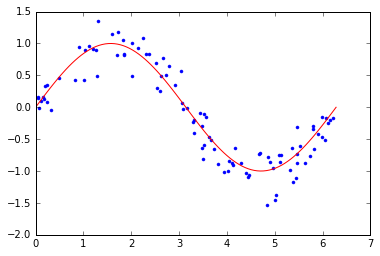

In [7]:

def gen_sinusoidal(N):
    sigma = 0.2
    x = np.random.uniform(0,2*np.pi, N)
    mu = np.sin(x)
    t = np.random.normal(mu, sigma, N)
    
    return x, t

N=100

x, t = gen_sinusoidal(N)

plt.plot(x, t, 'b.')
y = np.linspace(0, 2 * np.pi, N)
plt.plot(y, np.sin(y), 'r-')
plt.show()

### 2.2 Compute Posterior (15 points)

You're going to implement a Bayesian linear regression model, and fit it to the sinusoidal data. Your regression model has a zero-mean isotropic Gaussian prior over the parameters, governed by a single (scalar) precision parameter $\alpha$, i.e.:

$$p(\bw \;|\; \alpha) = \mathcal{N}(\bw \;|\; 0, \alpha^{-1} \bI)$$

The covariance and mean of the posterior are given by:

$$\bS_N= \left( \alpha \bI + \beta \bPhi^T \bPhi \right)^{-1} $$
$$\bm_N = \beta\; \bS_N \bPhi^T \bt$$

where $\alpha$ is the precision of the predictive distribution, and $\beta$ is the noise precision. 
See MLPR chapter 3.3 for background.

Write a method `fit_polynomial_bayes(x, t, M, alpha, beta)` that returns the mean $\bm_N$ and covariance $\bS_N$ of the posterior for a $M$-th order polynomial, given a dataset, where `x`, `t` and `M` have the same meaning as in question 1.2.

### 2.3 Prediction (10 points)

The predictive distribution of Bayesian linear regression is:

$$ p(t \;|\; \bx, \bt, \alpha, \beta) = \mathcal{N}(t \;|\; \bm_N^T \phi(\bx), \sigma_N^2(\bx))$$

$$ \sigma_N^2 = \frac{1}{\beta} + \phi(\bx)^T \bS_N \phi(\bx) $$

where $\phi(\bx)$ are the computed features for a new datapoint $\bx$, and $t$ is the predicted variable for datapoint $\bx$. 

Write a function that `predict_polynomial_bayes(x, m, S, beta)` that returns the predictive mean and variance given a new datapoint `x`, posterior mean `m`, posterior variance `S` and a choice of model variance `beta`.

### 2.4 Plot predictive distribution (10 points)

a) (5 points) Generate 7 datapoints with `gen_sinusoidal2(7)`. Compute the posterior mean and covariance for a Bayesian polynomial regression model with $M=5$, $\alpha=\frac{1}{2}$ and $\beta=\frac{1}{0.2^2}$.
Plot the Bayesian predictive distribution, where you plot (for $x$ between 0 and $2 \pi$) $t$'s predictive mean and a 1-sigma predictive variance using `plt.fill_between(..., alpha=0.1)` (the alpha argument induces transparency).

Include the datapoints in your plot.

b) (5 points) For a second plot, draw 100 samples from the parameters' posterior distribution. Each of these samples is a certain choice of parameters for 5-th order polynomial regression. 
Display each of these 100 polynomials.

### 2.5 Additional questions (10 points)

a) (5 points) Why is $\beta=\frac{1}{0.2^2}$ the best choice of $\beta$ in section 2.4?

b) (5 points) In the case of Bayesian linear regression, both the posterior of the parameters $p(\bw \;|\; \bt, \alpha, \beta)$ and the predictive distribution $p(t \;|\; \bw, \beta)$ are Gaussian. In consequence (and conveniently), $p(t \;|\; \bt, \alpha, \beta)$ is also Gaussian (See Bishop's book section 3.3.2 and homework 2 question 4). This is actually one of the (rare) cases where we can make Bayesian predictions without resorting to approximative methods.

Suppose you have to work with some model $p(t\;|\;x,\bw)$ with parameters $\bw$, where the posterior distribution $p(\bw\;|\;\mathcal{D})$ given dataset $\mathcal{D}$ can not be integrated out when making predictions, but where you can still generate samples from the posterior distribution of the parameters. Explain how you can still make approximate Bayesian predictions using samples from the parameters' posterior distribution.